In [1]:
from mantid import simpleapi as msa, mtd
import numpy as np, os, math
import scipy.optimize as sopt
from matplotlib import pyplot as plt

In [2]:
%matplotlib notebook

In [71]:
import align
reload(align)

<module 'align' from 'align.py'>

## Load difc

In [30]:
difc_table = msa.Load('./difc_cal.nxs')
difc_table = msa.SortTableWorkspace(difc_table, Columns='detid')

In [31]:
difc_table.getColumnNames()

['detid', 'difc', 'difa', 'tzero', 'tofmin', 'tofmax']

In [34]:
detID = np.array(difc_table.column('detid'))

In [32]:
difc = np.array(difc_table.column('difc'))

In [33]:
difc.size

115712

In [18]:
mask = np.load('./mask_difc.npy')

## Load L2

In [8]:
L2_calib = msa.Load('L2table.nxs')
L2_calib = msa.SortTableWorkspace(L2_calib, Columns='detid')

In [9]:
L2 = np.array(L2_calib.column('L2'))
L2.size

115712

In [10]:
L2_calib.getColumnNames()

['detid', 'L2', 'nodata']

In [11]:
nodata = np.array(L2_calib.column('nodata'), dtype=bool)

In [12]:
nodata.sum()

7647

In [19]:
mask = np.logical_or(mask, nodata)

In [20]:
mask

array([ True,  True,  True, ..., False, False, False], dtype=bool)

In [21]:
mask.sum()

11437

## Apply mask

In [22]:
difc = np.ma.masked_array(difc, mask)
L2 = np.ma.masked_array(L2, mask)

## Fit source, sample

In [23]:
import collections

In [24]:
import logging

In [25]:
logger = logging.getLogger("Align component")
logger.setLevel(logging.DEBUG)

# create console handler and set level to debug
ch = logging.StreamHandler()
ch.setLevel(logging.DEBUG)

# create formatter
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')

# add formatter to ch
ch.setFormatter(formatter)

# add ch to logger
logger.addHandler(ch)

In [26]:
eulerConvention='YZX'
wks_name = "alignedWorkspace"
idf_orig = os.path.join(msa.ConfigService.getInstrumentDirectory(), 'SEQUOIA_Definition.xml')
options = collections.OrderedDict()
options['Xposition']=False
options['Yposition']=False
options['Zposition']=(-1., 1.)
options['AlphaRotation']=False
options['BetaRotation']=False
options['GammaRotation']=False

In [27]:
# msa.DeleteWorkspace(wks_name)

In [40]:
msa.LoadEmptyInstrument(idf_orig, OutputWorkspace=wks_name)
instrument_model = align.InstrumentModel(wks_name, detID, mask, eulerConvention="YZX")

In [41]:
source_model = instrument_model.component('source')
fit = align.FitSourceSample(source_model, options, difc, logger)
fit.fit()

2017-09-21 16:33:06,960 - Align component - INFO - Working on SEQUOIA/moderator. Starting position is [0.0, 0.0, -20.0114], Starting rotation is [0.0, 0.0, -0.0]
2017-09-21 16:33:08,634 - Align component - INFO - Finished optimizing SEQUOIA/moderator. Final position is [0.0, 0.0, -20.096528470257276], Final rotation is [0.0, 0.0, -0.0]


In [42]:
source_model.getParams()

[0.0, 0.0, -20.096528470257276, 0.0, 0.0, -0.0]

In [53]:
#sample_model = instrument_model.component('sample')
#fit = FitSourceSample(sample_model, options, difc, logger)
#fit.fit()

## Fit twotheta and L2

$ DIFC = (L1+L2)/(\pi) \; sin(\theta) \times 0.0015882549421289758 \times 10^6 $

### First check the calibrated result is mostly in agreement with nominal values

In [43]:
instrument = mtd[wks_name].getInstrument()

In [44]:
print instrument.getSource().getPos()
print instrument.getSample().getPos()

[0,0,-20.0965]
[0,0,0]


In [45]:
L1 = instrument.getSample().getPos()[2]-instrument.getSource().getPos()[2]
L1

20.096528470257276

In [46]:
L1_orig = 20.0114

L2 has to be adjusted because it was computed from V data assuming the L1 is 20.0114

In [47]:
L2_corrected = L2 + (L1_orig - L1)

In [48]:
sin_theta = difc/(0.0015882549421289758*1e6) * np.pi / (L1+L2_corrected)

/usr/lib/python2.7/dist-packages/numpy/ma/core.py:812: RuntimeWarning: invalid value encountered in greater_equal
  return umath.absolute(a) * self.tolerance >= umath.absolute(b)


In [49]:
sin_theta[~sin_theta.mask][:10]

masked_array(data = [0.47593054859274114 0.4756231443994385 0.47987923558631995
 0.46481637410416105 0.47801594843167833 0.47693295523319557
 0.4782886493569799 0.47802383739567256 0.4763788048079743
 0.4774067639355043],
             mask = [False False False False False False False False False False],
       fill_value = 1e+20)

In [50]:
pp = msa.PreprocessDetectorsToMD(InputWorkspace=wks_name, OutputWorkspace='pp')
pp = msa.SortTableWorkspace(pp, Columns='DetectorID')

detid1 = np.array(pp.column('DetectorID'))
isdet = detid1>0
twotheta_nominal = np.array( pp.column('TwoTheta') )[isdet]
sin_theta_nominal = np.sin(twotheta_nominal/2.)
sin_theta_nominal = np.ma.masked_array(sin_theta_nominal, mask)

In [51]:
sin_theta_nominal[~sin_theta_nominal.mask][:10]

masked_array(data = [0.4758458573350526 0.4756890361446189 0.4755326882839453
 0.47537681734915627 0.4752214269386242 0.47506652065279403
 0.47491210209400847 0.47475817486633076 0.47460474257536683
 0.47445180882808524],
             mask = [False False False False False False False False False False],
       fill_value = 1e+20)

## Fit only difc

In [54]:
options = collections.OrderedDict()
options['Xposition']=(-.2, .2)
options['Yposition']=False
options['Zposition']=(-.2, .2)
options['AlphaRotation']=False
options['BetaRotation']=False
options['GammaRotation']=False

In [55]:
print options

OrderedDict([('Xposition', (-0.2, 0.2)), ('Yposition', False), ('Zposition', (-0.2, 0.2)), ('AlphaRotation', False), ('BetaRotation', False), ('GammaRotation', False)])


In [57]:
msa.LoadEmptyInstrument(idf_orig, OutputWorkspace=wks_name)
instrument_model = align.InstrumentModel(wks_name, detID, mask, eulerConvention="YZX")

In [58]:
pack_model = instrument_model.component('B10/eightpack', type='detpack')

In [59]:
pack_model.getParams()

[3.20998708014, -1.29480004006, 4.30555569164, -143.29380037000004, 0.0, -0.0]

In [61]:
fit = align.FitPackDifc(pack_model, options, difc, logger)

fit.fit()

2017-09-21 18:53:59,616 - Align component - INFO - Working on SEQUOIA/B row/B10/eightpack. Starting position is [3.20998708014, -1.29480004006, 4.30555569164], Starting rotation is [-143.29380037000004, 0.0, -0.0]
2017-09-21 18:56:38,688 - Align component - INFO - Finished optimizing SEQUOIA/B row/B10/eightpack. Final position is [3.1004827957168946, -1.29480004006, 4.10555569164], Final rotation is [-143.29380037000004, 0.0, -0.0]


In [62]:
pack_model.getParams()

[3.1004827957168946,
 -1.29480004006,
 4.10555569164,
 -143.29380037000004,
 0.0,
 -0.0]

This is way too big a change. difc along does not constrain very well

## Fit using twotheta and L2

In [72]:
msa.LoadEmptyInstrument(idf_orig, OutputWorkspace=wks_name)
instrument_model = align.InstrumentModel(wks_name, detID, mask, eulerConvention="YZX")

In [73]:
pack_model = instrument_model.component('B10/eightpack', type='detpack')

In [74]:
pack_model.getParams()

[3.20998708014, -1.29480004006, 4.30555569164, -143.29380037000004, 0.0, -0.0]

In [75]:
saved_difc = pack_model.difc()
saved_twotheta, saved_L2 = pack_model.twotheta_and_L2()

In [76]:
options = collections.OrderedDict()
options['Xposition']=(-.2, .2)
options['Yposition']=False
options['Zposition']=(-.2, .2)
options['AlphaRotation']=(-5., 5.)
options['BetaRotation']=False
options['GammaRotation']=False 

fit = align.FitPackTwothetaAndL2(pack_model, options, sin_theta, L2, logger)
fit.fit()

2017-09-21 19:59:50,185 - Align component - INFO - Working on SEQUOIA/B row/B10/eightpack. Starting position is [3.20998708014, -1.29480004006, 4.30555569164], Starting rotation is [-143.29380037000004, 0.0, -0.0]


2.61978377783e-05
2.61978239854e-05
2.6197847179e-05
2.61978377781e-05
2.35763451915e-05
2.3576332928e-05
2.35763533325e-05
2.35763451913e-05
1.42649955851e-05
1.42649951545e-05
1.42649949718e-05
1.42649955849e-05
1.42296011877e-05
1.42296010175e-05
1.42296008762e-05
1.42296011875e-05
1.42196905639e-05
1.42196905639e-05
1.42196905638e-05


2017-09-21 19:59:54,122 - Align component - INFO - Finished optimizing SEQUOIA/B row/B10/eightpack. Final position is [3.223249036925353, -1.29480004006, 4.299520305209903], Final rotation is [-143.29379934038187, 0.0, 0.0]


1.42196905636e-05


In [77]:
pack_model.getParams()

[3.223249036925353,
 -1.29480004006,
 4.299520305209903,
 -143.29379934038187,
 0.0,
 0.0]

<IPython.core.display.Javascript object>


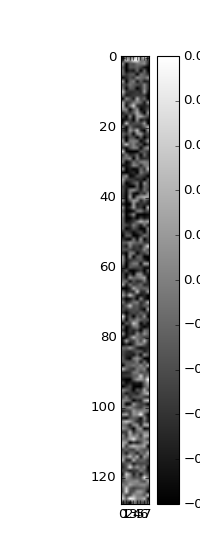

In [82]:
old_diff_L2 = saved_L2- fit.L2
old_diff_L2.shape = 8,128

plt.figure(figsize=(2.5,7))
plt.imshow(old_diff_L2.T, cmap='gray')
plt.clim(-.01, .01)
plt.colorbar()

In [83]:
new_twotheta, new_L2 = pack_model.twotheta_and_L2()

<IPython.core.display.Javascript object>


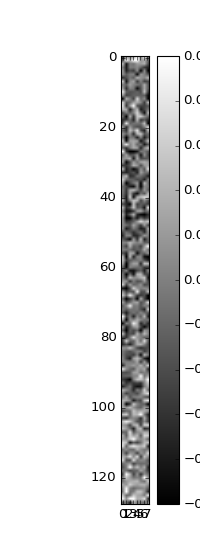

In [84]:
new_diff_L2 = new_L2 - fit.L2
new_diff_L2.shape = 8,128

plt.figure(figsize=(2.5,7))
plt.imshow(new_diff_L2.T, cmap='gray')
plt.clim(-.01, .01)
plt.colorbar()

In [85]:
target_L2 = fit.L2.copy()
new_L2.shape = saved_L2.shape = target_L2.shape = 8, 128

In [86]:
print target_L2[:, 0]
print new_L2[:, 0]
print saved_L2[:, 0]

[5.702991962432861 5.692929744720459 5.695333957672119 5.693321228027344
 5.682201862335205 5.695701599121094 5.684253215789795 5.697860240936279]
[5.6973403680078905 5.696875541969483 5.696542779765271 5.696342104539513
 5.696273530252162 5.696337061674039 5.696532694385155 5.696860414776265]
[5.694169876897138 5.693773397242648 5.693509062132193 5.693376889971604
 5.693376889965396 5.693509062113573 5.693773397211615 5.694169876853694]


In [87]:
new_difc = pack_model.difc()

In [88]:
new_difc

masked_array(data = [4644.7481894628545 4640.496869090217 4636.258351829861 4632.032728549799
 4627.8200903021425 4623.620528319041 4619.434134008539 4615.260998950409
 4611.1012148919035 4606.954873743446 4602.822067574278 4598.702888608028
 4594.597429218226 4590.505781923781 4586.428039384348 4582.364294395692
 4578.314639884954 4574.279168905869 4570.257974633923 4566.251150361461
 4562.25878949271 4558.280985538764 4554.317832112511 4550.3694229234725
 4546.435851772625 4542.517212547118 4538.61359921498 4534.72510581971
 4530.851826474868 4526.993855358554 4523.15128670788 4519.324214813326
 4515.512734013092 4511.716938687361 4507.936923252502 4504.172782155244
 4500.424609866756 4496.692500876699 4492.976549687203 4489.2768508068075
 4485.593498744314 4481.926588002621 4478.276213072482 4474.642468426208
 4471.025448511319 4467.425247744148 4463.84196050339 4460.275681123581
 4456.726503888561 4453.194523024835 4153.95808819156 4150.795454093737
 4147.653883693715 4144.53347615

In [89]:
difc[pack_model.firstIndex:pack_model.lastIndex+1]

array([ 4630.75082726,  4626.47909763,  4673.75054665, ...,  4049.15347123,
        4011.3392467 ,  4009.28051998])

## D23

In [91]:
msa.LoadEmptyInstrument(idf_orig, OutputWorkspace=wks_name)
instrument_model = align.InstrumentModel(wks_name, detID, mask, eulerConvention="YZX")

In [92]:
d23_model = instrument_model.component('D23/eightpack', type='detpack')

In [93]:
d23_model.getParams()

[0.565047087836, 1.22910000001, 5.3415347703, -173.96150000000003, 0.0, -0.0]

In [94]:
d23_saved_difc = d23_model.difc()
d23_saved_twotheta, d23_saved_L2 = d23_model.twotheta_and_L2()

In [96]:
options = collections.OrderedDict()
options['Xposition']=(-.3, .3)
options['Yposition']=False
options['Zposition']=(-.3, .3)
options['AlphaRotation']=(-5., 5.)
options['BetaRotation']=False
options['GammaRotation']=False 

fit_d23 = align.FitPackTwothetaAndL2(d23_model, options, sin_theta, L2, logger)
fit_d23.fit()

2017-09-21 20:02:17,937 - Align component - INFO - Working on SEQUOIA/D row/D23/eightpack. Starting position is [0.565047087836, 1.22910000001, 5.3415347703], Starting rotation is [-173.96150000000003, 0.0, -0.0]


0.00111854859155
0.00111854866446
0.00111854858006
0.00111854859156
0.00107286112714
0.00107286117758
0.00107286112535
0.00107286112715
0.0010229877884
0.00102298779291
0.00102298780283
0.00102298778841
0.00101484578844
0.00101484578675
0.00101484580123
0.00101484578845
0.0010052284807
0.00100522847851
0.00100522848255
0.00100522848071
0.00100507724167
0.00100507724159


2017-09-21 20:02:22,757 - Align component - INFO - Finished optimizing SEQUOIA/D row/D23/eightpack. Final position is [0.5295633323408481, 1.22910000001, 5.318315903116428], Final rotation is [-173.96152685790986, 0.0, 0.0]


0.00100507724171
0.00100507724168


In [97]:
d23_model.getParams()

[0.5295633323408481,
 1.22910000001,
 5.318315903116428,
 -173.96152685790986,
 0.0,
 0.0]

<IPython.core.display.Javascript object>


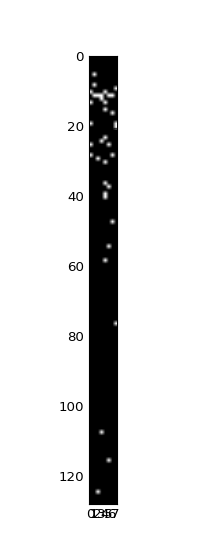

In [105]:
d23_mask = d23_model.mask.copy()
d23_mask.shape = 8, -1
plt.figure(figsize=(2.5, 7))
plt.imshow(d23_mask.T, cmap='gray')

<IPython.core.display.Javascript object>


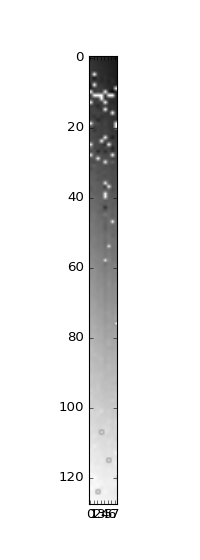

In [106]:
d23_sin_theta = sin_theta[d23_model.firstIndex: d23_model.lastIndex+1].copy()
# print d23_sin_theta.shape
d23_sin_theta.shape = 8, 128
plt.figure(figsize=(2.5, 7))
plt.imshow(d23_sin_theta.T, cmap='gray')

In [107]:
d23_model.firstIndex, d23_model.lastIndex

(100352, 101375)

In [108]:
d23_center_sin_theta = np.average(d23_sin_theta[3:5, 62:66])
print d23_center_sin_theta

0.12253042552


In [109]:
d23_center_twotheta = np.arcsin(d23_center_sin_theta)*2

In [110]:
d23_L2 = L2[d23_model.firstIndex:d23_model.lastIndex+1].copy()
print d23_L2.shape
d23_L2.shape = 8, 128
d23_center_L2 = np.average(d23_L2[3:5, 62::66])
print d23_center_L2

(1024,)
5.49990344048


In [111]:
y_center = 1.22910000001
z_center = d23_center_L2 * np.cos(d23_center_twotheta)
x_center = (d23_center_L2**2 - z_center**2 - y_center**2)**.5 * np.sign(0.565047087836)
print x_center, y_center, z_center

0.527857854661 1.22910000001 5.33475558295


In [112]:
fit_d23.cost((0.527857854661, 5.33475558295, -178.19560855381187))

0.00102306363585


0.0010230636358541908

In [113]:
new_tt, new_L2 = d23_model.twotheta_and_L2()

In [114]:
np.sin(new_tt/2.)

masked_array(data = [0.0825414758200517 0.08315106422404811 0.08376469075363041
 0.08438225128588339 0.08500364396577251 0.08562876917171217
 0.08625752947996387 0.08688982962805097 0.0875255764773415
 0.08816467897496683 -- 0.08945259690051507 0.09010124030216599 --
 0.09140748044723584 0.0920649166222482 0.0927251261979129
 0.09338803339803042 0.09405356417923946 -- 0.09539220874412749
 0.09606518275927026 0.09674050074312619 0.09741809674469235
 0.09809790632021165 -- 0.09946391573975853 0.1001499939126936 --
 0.10152800331401805 0.10221982097635418 0.10291344037211782
 0.1036088078752261 0.10430587106619618 0.10500457870196442
 0.10570488068636537 0.1064067280412727 0.10711007287839092
 0.10781486837171 0.10852106873060217 0.10922862917356248
 0.10993750590258751 0.11064765607818036 0.11135903779497404
 0.11207161005796852 0.11278533275936657 0.11350016665600161
 0.11421607334734676 0.11493301525409318 0.11565095559728905
 0.13065437827022058 0.1314286294664055 0.132202622458828
 0

In [115]:
fit_d23.sin_theta

masked_array(data = [0.08495134844680403 0.08549559146219335 0.08610198370459295
 0.08669447442876008 0.08614319282759095 0.08743742786009982
 0.08853526150317421 0.08915853616465744 0.07599413151762867
 0.07547595139461688 -- 0.09161150499845709 0.09228333194387439 --
 0.08962835350680491 0.09177851176434196 0.09031098436190724
 0.09115893459036598 0.09299391389907509 -- 0.09750334807239448
 0.09613920210326032 0.09626526579756521 0.09643173990601427
 0.0973847749654481 -- 0.10827504601131674 0.09669437695449788 --
 0.09911230417155721 0.09703749373709371 0.1026165266501574
 0.09678189802798728 0.1036065245055841 0.10448963102769228
 0.10539364943036289 0.10711727255395126 0.10395282060623855
 0.10190732857240184 0.10826335063059117 0.10860309996719625
 0.11075970691370142 0.11144084189213939 0.11071782852279922
 0.11271299536717036 0.11345785005643999 0.11426491009813462
 0.11435385406928382 0.11840471970463443 0.11618612345708533
 0.13501410420165247 0.1364063863750004 0.13662033159

## C21

In [116]:
msa.LoadEmptyInstrument(idf_orig, OutputWorkspace=wks_name)
instrument_model = align.InstrumentModel(wks_name, detID, mask, eulerConvention="YZX")

In [117]:
c21_model = instrument_model.component('C21/eightpack', type='detpack')
print c21_model.getParams()

[0.955168885442, -0.0389000000002, 5.42691364704, -170.01784216, 0.0, -0.0]


In [118]:
options = collections.OrderedDict()
options['Xposition']=(-.3, .3)
options['Yposition']=False
options['Zposition']=(-.3, .3)
options['AlphaRotation']=(-5., 5.)
options['BetaRotation']=False
options['GammaRotation']=False 

fit_c21 = align.FitPackTwothetaAndL2(c21_model, options, sin_theta, L2, logger)
fit_c21.fit()

2017-09-21 20:06:15,779 - Align component - INFO - Working on SEQUOIA/C row/C21/eightpack. Starting position is [0.955168885442, -0.0389000000002, 5.42691364704], Starting rotation is [-170.01784216, 0.0, -0.0]


0.000297018868358
0.000297018672485
0.000297018907538
0.000297018868356
0.000229733246197
0.000229733376532
0.000229733221317
0.000229733246199
0.000176941629344
0.000176941629317
0.000176941630297
0.000176941629344
0.000176936412727
0.000176936412897
0.000176936413605
0.000176936412727
0.000176920117824
0.000176920118779
0.000176920118401
0.000176920117824
0.000176883799817
0.000176883801035
0.000176883799848
0.000176883799817
0.000176874122957
0.000176874123105
0.000176874122932
0.000176874122957
0.000176874054301
0.000176874054312
0.000176874054297


2017-09-21 20:06:22,072 - Align component - INFO - Finished optimizing SEQUOIA/C row/C21/eightpack. Final position is [0.966662578517161, -0.0389000000002, 5.423089352864223], Final rotation is [-170.01784247513322, 0.0, 0.0]


0.000176874054301


In [119]:
print c21_model.getParams()

[0.966662578517161, -0.0389000000002, 5.423089352864223, -170.01784247513322, 0.0, 0.0]
